<a href="https://colab.research.google.com/github/annabelleshea/yelp_final/blob/main/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dask[dataframe]
!pip install dask[distributed]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import contextily as ctx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MGSC 410 Final Project/cleaned_data.csv')

In [ ]:
# Drop rows with missing values
data = data.dropna(subset=['user_rating_variance'])

In [ ]:
# See how many rows of data are left after cleaning
print(len(data))

395682


##EDA

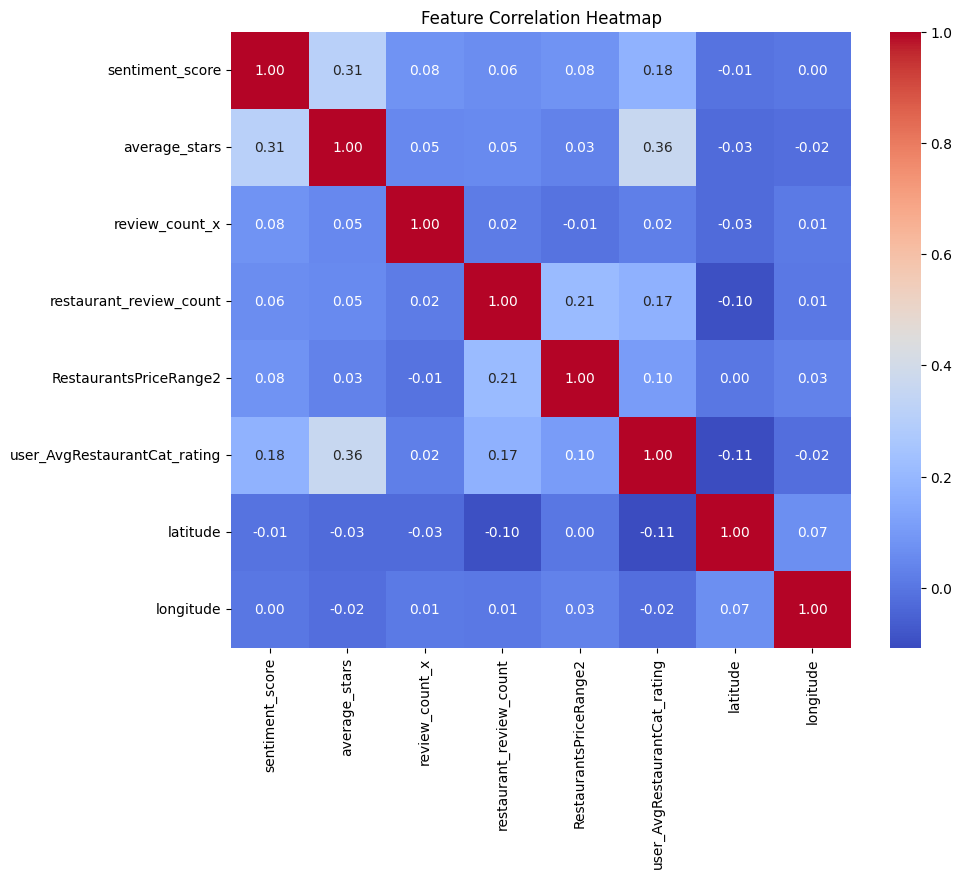

In [ ]:
# Select only numerical columns
numerical_features = ['sentiment_score', 'average_stars', 'review_count_x',
                      'restaurant_review_count', 'RestaurantsPriceRange2',
                      'user_AvgRestaurantCat_rating', 'latitude', 'longitude']

# Compute correlation matrix
corr_matrix = data[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

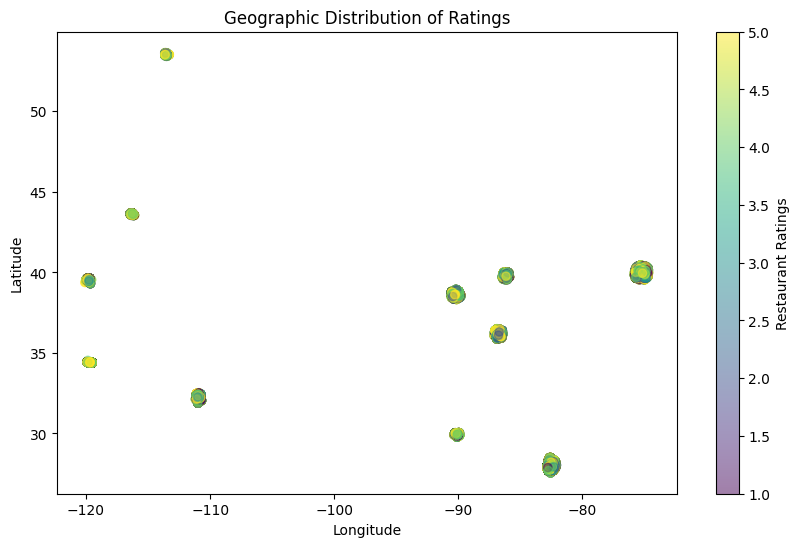

In [ ]:
# Scatter plot of latitude vs longitude colored by rating
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['rating'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Restaurant Ratings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Ratings')
plt.show()

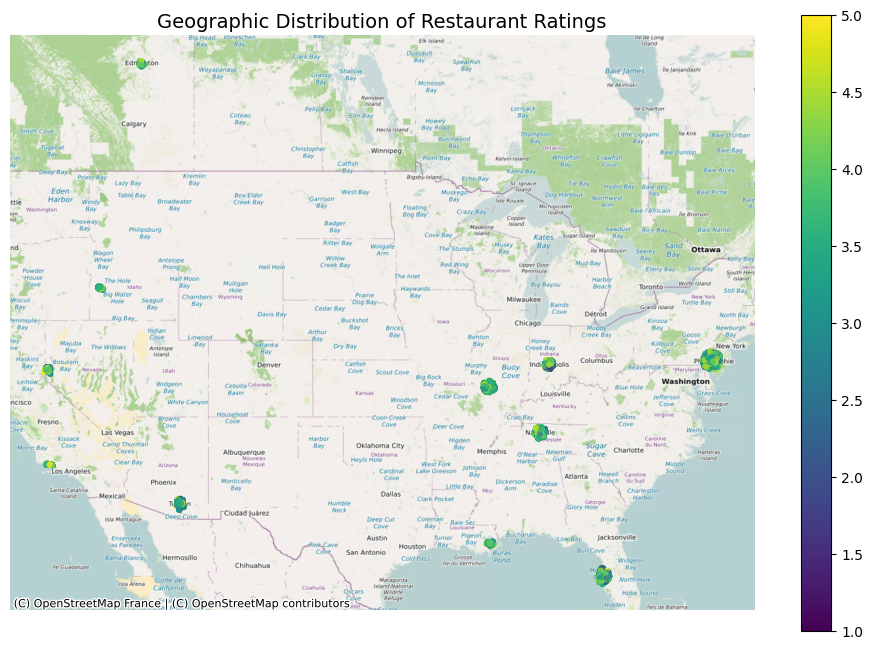

In [ ]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(data,
                       geometry=gpd.points_from_xy(data['longitude'], data['latitude']),
                       crs="EPSG:4326")  # Initial projection: WGS 84

# Reproject the data to match basemap CRS
gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection for contextily basemaps

# Plot the data with basemap
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax,
         column='stars',   # Color by restaurant ratings
         cmap='viridis',   # Color map
         markersize=10,    # Size of the points
         legend=True,      # Show legend
         alpha=0.6)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.France, zoom=5)

# Set plot aesthetics
ax.set_title("Geographic Distribution of Restaurant Ratings", fontsize=14)
ax.set_axis_off()  # Clean up axis for visualization

plt.show()


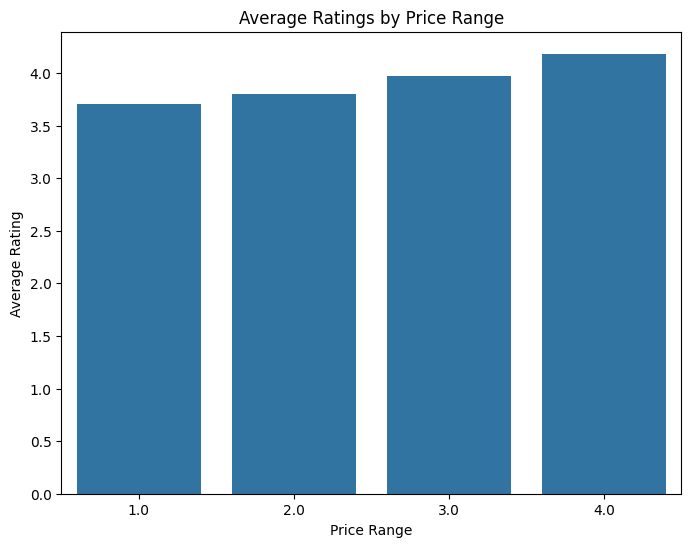

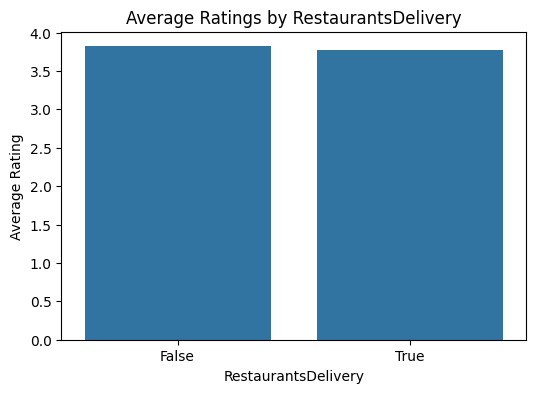

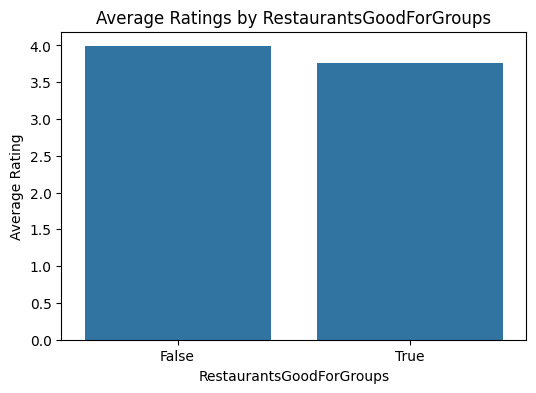

In [ ]:
# Grouping data by 'RestaurantsPriceRange2' and calculating mean ratings
price_group = data.groupby('RestaurantsPriceRange2')['rating'].mean().reset_index()

# Bar chart for price range vs average rating
plt.figure(figsize=(8, 6))
sns.barplot(x='RestaurantsPriceRange2', y='rating', data=price_group)
plt.title('Average Ratings by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Average Rating')
plt.show()

# Analyzing the impact of attributes like 'RestaurantsDelivery' and 'GoodForGroups'
attributes = ['RestaurantsDelivery', 'RestaurantsGoodForGroups']
for attr in attributes:
    attr_group = data.groupby(attr)['rating'].mean().reset_index()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=attr, y='rating', data=attr_group)
    plt.title(f'Average Ratings by {attr}')
    plt.ylabel('Average Rating')
    plt.xlabel(attr)
    plt.show()


##BASELINE MODEL

In [ ]:
# BASELINE MODEL
# Select relevant features and target
features = [
    'review_count_x', 'fans', 'average_stars', 'restaurant_review_count', 'latitude',
    'longitude', 'is_open', 'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2',
    'Alcohol_full_bar', 'Alcohol_none', 'Alcohol_full_bar', 'Alcohol_beer_and_wine',
    'Parking_lot', 'RestaurantsTakeOut', 'RestaurantsDelivery',
    'OutdoorSeating',	'HasTV',	'RestaurantsReservations',	'GoodForKids',
    'RestaurantsTableService',	'RestaurantsGoodForGroups',	'DriveThru', 'BYOB',	'Corkage',
    'Open24Hours', 'RestaurantsCounterService', 'Parking_street',	'Parking_validated',
    'Parking_lot', 'Parking_garage', 'hipster', 'casual', 'touristy', 'romantic', 'divey',
    'intimate', 'trendy', 'upscale', 'classy', 'RestaurantsAttire_casual',
    'RestaurantsAttire_dressy', 'RestaurantsAttire_formal',
    'user_AvgRestaurantCat_rating', 'dessert',	'latenight',	'lunch',	'dinner',
    'brunch', 'breakfast', 'sentiment_score', 'user_rating_variance', 'hour_of_day',
    'is_weekend', 'is_in_best_food_city'
]
X = data[features]
y = data['rating']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit and predict
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print(f"R²: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


## LASSO REGRESSION WITH GRIDSEARCH CV

In [ ]:
# LASSO REGRESSION
# Define Lasso pipeline with scaling
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('lasso', Lasso())             # Lasso regression model
])

# Define the parameter grid
param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

# Fit GridSearchCV
grid_search = GridSearchCV(lasso_pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best alpha
best_alpha = grid_search.best_params_['lasso__alpha']
print(f"Best alpha: {best_alpha}")

# Refit Lasso with the best alpha
best_lasso = grid_search.best_estimator_
y_pred_best = best_lasso.predict(X_test)

# Calculate metrics
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"Optimized Lasso Results:")
print(f"R²: {r2_best:.4f}")
print(f"Mean Absolute Error (MAE): {mae_best:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best:.4f}")

In [ ]:
# Extract feature names and coefficients
lasso_model = best_lasso.named_steps['lasso']  # Access the Lasso model from the pipeline
coefficients = lasso_model.coef_  # Lasso coefficients
feature_names = X_train.columns  # Feature names

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)  # Sort by absolute importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()
plt.show()

## GRID SEARCH CV TO FIND BEST KNN MODEL PARAMETERS

In [ ]:
# GRID SEARCH CV FOR BEST KNN MODEL PARAMETERS USING SAMPLE OF DATA
# Predefined features
features = [
    'review_count_x', 'average_stars', 'restaurant_review_count', 'latitude',
    'is_open', 'longitude',
    'Alcohol_full_bar', 'Alcohol_beer_and_wine',
    'RestaurantsDelivery',
    'HasTV',
    'RestaurantsTableService', 'RestaurantsGoodForGroups', 'DriveThru',
    'Parking_street',
    'touristy',
    'intimate', 'classy', 'RestaurantsAttire_casual',
    'user_AvgRestaurantCat_rating', 'latenight',
    'sentiment_score', 'hour_of_day',
    'is_weekend', 'is_in_best_food_city'
]

# Prepare the data
def prepare_time_aware_split(data):
    # Convert date to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Sort data by date within each user group
    data_sorted = data.sort_values(['user_id', 'date'])

    # Create test set with most recent review per user
    test_mask = data_sorted.groupby('user_id')['date'].transform('max') == data_sorted['date']
    X_test = data_sorted[test_mask][features]
    y_test = data_sorted[test_mask]['rating']

    # Remove test set from training data
    train_cv_data = data_sorted[~test_mask]

    # Create cross-validation set with second most recent review per user
    cv_mask = train_cv_data.groupby('user_id')['date'].transform('max') == train_cv_data['date']
    X_cv = train_cv_data[cv_mask][features]
    y_cv = train_cv_data[cv_mask]['rating']

    # Remaining data becomes training set
    X_train = train_cv_data[~cv_mask][features]
    y_train = train_cv_data[~cv_mask]['rating']

    return X_train, y_train, X_cv, y_cv, X_test, y_test


# Randomly sample smaller chunk of data for efficiency
sample_data = data.sample(n=50000, random_state=42)  # Randomly sample 50,000 rows

# Prepare the data split on the sampled data
X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_time_aware_split(sample_data)

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Perform GridSearch with Cross-Validation
param_grid = {
    'knn__n_neighbors': [3, 5, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1  # Distribute computation across available workers
)

# Train the model with hyperparameter tuning using training and validation
grid_search.fit(X_train, y_train)

# Output the best hyperparameters found
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Get the best pipeline model
best_model = grid_search.best_estimator_

# Evaluate the model's performance on the CV set
y_cv_pred = best_model.predict(X_cv)
mse_cv = mean_squared_error(y_cv, y_cv_pred)
print(f"Cross-validation Mean Squared Error: {mse_cv}")

# Evaluate performance on test set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {mse_test}")


## FINAL KNN MODEL

In [ ]:
# KNN MODEL WITH BEST PARAMETERS FROM GRID SEARCH CV
# Prepare the data
features = [
    'review_count_x', 'average_stars', 'restaurant_review_count', 'latitude',
    'is_open', 'longitude',
    'Alcohol_full_bar', 'Alcohol_beer_and_wine',
    'RestaurantsDelivery',
    'HasTV',
    'RestaurantsTableService', 'RestaurantsGoodForGroups', 'DriveThru',
    'Parking_street',
    'touristy',
    'intimate', 'classy', 'RestaurantsAttire_casual',
    'user_AvgRestaurantCat_rating', 'latenight',
    'sentiment_score', 'hour_of_day',
    'is_weekend', 'is_in_best_food_city'
]

def prepare_time_aware_split(data):
    # Convert date to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Sort data by date within each user group
    data_sorted = data.sort_values(['user_id', 'date'])

    # Create test set with most recent review per user
    test_mask = data_sorted.groupby('user_id')['date'].transform('max') == data_sorted['date']
    X_test = data_sorted[test_mask][features]
    y_test = data_sorted[test_mask]['rating']

    # Remove test set from training data
    train_cv_data = data_sorted[~test_mask]

    # Create cross-validation set with second most recent review per user
    cv_mask = train_cv_data.groupby('user_id')['date'].transform('max') == train_cv_data['date']
    X_cv = train_cv_data[cv_mask][features]
    y_cv = train_cv_data[cv_mask]['rating']

    # Remaining data becomes training set
    X_train = train_cv_data[~cv_mask][features]
    y_train = train_cv_data[~cv_mask]['rating']

    return X_train, y_train, X_cv, y_cv, X_test, y_test

# Prepare the data split
X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_time_aware_split(data)

# Define pipeline with fixed hyperparameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(
        n_neighbors=10,  # Number of neighbors
        weights='distance',  # Weight function
        p=2  # Power parameter for Minkowski distance (p=2 for Euclidean distance)
    ))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate performance on CV set
y_cv_pred = pipeline.predict(X_cv)
mse_cv = mean_squared_error(y_cv, y_cv_pred)
print(f"Cross-validation Mean Squared Error: {mse_cv}")

# Evaluate performance on test set
y_test_pred = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {mse_test}")


Cross-validation Mean Squared Error: 1.1250931920084115
Test Mean Squared Error: 1.1456423248092913


In [ ]:
r2 = r2_score(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test Mean Squared Error: {mse_test}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R²: {r2}")

Test Mean Squared Error: 1.1456423248092913
Test RMSE: 1.0703468245430037
Test MAE: 0.8380388780255549
Test R²: 0.4365546597421379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'best_knnModel.pkl')

<ipython-input-18-8d9a70b09de0>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_over_time = test_data.groupby('month').apply(


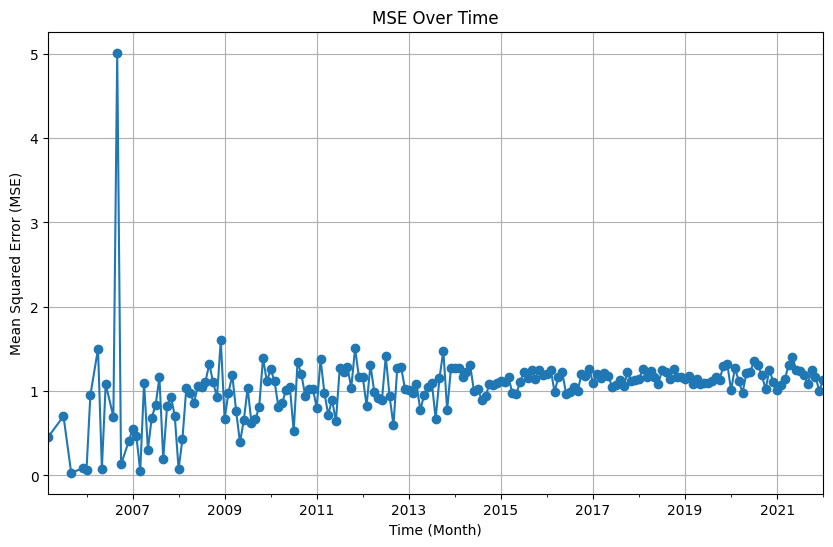

In [ ]:
# PLOTTING KNN MSE OVER TIME
# Add predictions and residuals to the test data for analysis
test_data = X_test.copy()
test_data['date'] = data.loc[X_test.index, 'date']
test_data['actual_rating'] = y_test.values
test_data['predicted_rating'] = y_test_pred
test_data['residual'] = residuals

# Group by time and calculate MSE over time
test_data['month'] = test_data['date'].dt.to_period('M')
mse_over_time = test_data.groupby('month').apply(
    lambda df: mean_squared_error(df['actual_rating'], df['predicted_rating'])
)

# Line plot of MSE over time
plt.figure(figsize=(10, 6))
mse_over_time.plot(kind='line', marker='o')
plt.title('MSE Over Time')
plt.xlabel('Time (Month)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

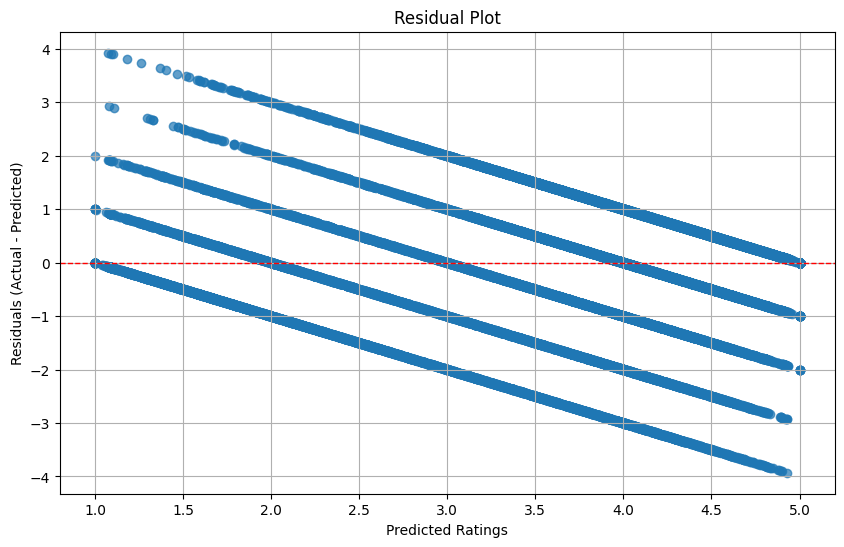

In [ ]:
# Residuals
residuals = y_test - y_test_pred

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

## ADDITIONAL VIZ WE ATTEMPTED

In [ ]:
# SHAP SUMMARY PLOT WAS TOO COMPUTATIONALLY EXPENSIVE
# import shap
# import pandas as pd

# # Reduce the background dataset size using sampling or k-means clustering
# # Choose one method:
# background = shap.sample(X_train, 100)  # Randomly sample 100 instances
# # background = shap.kmeans(X_train, 100)  # Summarize the background with 100 clusters

# # Ensure the background is in array format
# background_array = background.to_numpy() if isinstance(background, pd.DataFrame) else background

# # Ensure X_train and X_test are compatible
# X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
# X_test_array = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# # Define a prediction function that works with the pipeline
# def predict_fn(X):
#     return best_model.predict(pd.DataFrame(X, columns=features))  # Wrap the input in a DataFrame

# # Reinitialize SHAP KernelExplainer with the reduced background
# explainer = shap.KernelExplainer(predict_fn, background_array)

# # Compute SHAP values with reduced background
# shap_values = explainer.shap_values(X_test_array, nsamples=100)

# # SHAP summary plot
# shap.summary_plot(shap_values, X_test_array, feature_names=features)


In [ ]:
# SHAP DEPENDENCE PLOT WAY TOO COMPUTATIONALLY EXPENSIVE
# import shap
# import pandas as pd

# # Assign the trained pipeline to best_model
# best_model = pipeline

# # Reduce the background dataset size using sampling or k-means clustering
# background = shap.sample(X_train, 100)  # Randomly sample 100 instances for the background

# # Ensure the background is in array format
# background_array = background.to_numpy() if isinstance(background, pd.DataFrame) else background

# # Ensure X_train and X_test are compatible
# X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
# X_test_array = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# # Reduce the test set size to 500 samples for efficiency
# X_test_sample = X_test.sample(500, random_state=42)
# X_test_sample_array = X_test_sample.to_numpy() if isinstance(X_test_sample, pd.DataFrame) else X_test_sample

# # Define a prediction function that works with the pipeline
# def predict_fn(X):
#     return best_model.predict(pd.DataFrame(X, columns=features))  # Wrap the input in a DataFrame

# # Initialize SHAP KernelExplainer with the reduced background
# explainer = shap.KernelExplainer(predict_fn, background_array)

# # Compute SHAP values for the sampled test set with fewer SHAP samples (nsamples=10)
# shap_values = explainer.shap_values(X_test_sample_array, nsamples=10)  # Faster computation with lower nsamples

# # Generate SHAP dependence plot for a specific feature (e.g., 'average_stars')
# shap.dependence_plot('average_stars', shap_values, X_test_sample_array, feature_names=features)


In [ ]:
# PERMUTATION IMPORTANCE PLOT WAS TOO COMPUTATIONALLY EXPENSIVE
#  from sklearn.inspection import permutation_importance

# # Perform permutation importance
# result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# # Display feature importance
# for i in result.importances_mean.argsort()[::-1]:
#     print(f"Feature: {features[i]}, Importance: {result.importances_mean[i]:.4f}")